In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from scipy import stats

from collections import defaultdict
from functools import partial
import os
import re

from tensorflow.python.summary.summary_iterator import summary_iterator
import tensorflow as tf
%matplotlib inline
from matplotlib import rcParams
# Set Helvetica as the default font
rcParams['pdf.use14corefonts'] = True  # Ensures Type 1 fonts (including Helvetica) are used
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Helvetica']
rcParams['figure.figsize'] = [4, 3]

2024-12-16 22:59:50.943853: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 22:59:50.944051: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-16 22:59:50.945933: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-16 22:59:50.968463: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 22:59:51.439041: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
log_dir = os.path.join(os.getcwd(), "../.runs/seq_multiseed/cifar10")

In [3]:
experiments = os.listdir(log_dir)
experiments

['sgd_1_of_2',
 'sgd_2_of_2_pca',
 'mfvi_2_of_2_pca',
 'mfvi_1_of_2',
 'mfvi_2_of_2',
 'sgd_2_of_2_from_split1_init',
 'sgd_2_of_2_stratified_from_split1_init',
 'sgd_2_of_2_stratified',
 'mfvi_1_of_2_pca',
 'sgd_2_of_2',
 'mfvi_1_of_2_stratified',
 'mfvi_2_of_2_stratified',
 'sgd_1_of_2_pca',
 'sgd_1_of_2_stratified',
 'sgd_2_of_2_pca_from_split1_init']

## Utils to load experiment results

In [4]:
def parse_sgd_events(eventfile):
    value_by_tag = defaultdict(dict)
    for event in summary_iterator(eventfile):
        for value in event.summary.value:
            value_by_tag[value.tag][event.step] = tf.make_ndarray(value.tensor).squeeze()
    df = pd.DataFrame(value_by_tag).rename_axis("step")
    return df.drop(columns=['command']).astype(float)

In [5]:
def load_sgd_experiment_logs(experiment, experiment_instance=None, events_log=None):
    if experiment_instance is None:
        instances = os.listdir(os.path.join(log_dir, experiment))
        assert len(instances) == 1, f"Manually need to provice experiment instance: {instances}"
        experiment_instance = instances[0]
    if events_log is None:
        events_log = max((os.path.getmtime(os.path.join(log_dir, experiment, experiment_instance, filename)), filename)
                                for filename in filter(
                                    lambda filename: filename.startswith("event"),
                                    os.listdir(os.path.join(log_dir, experiment, experiment_instance))
                                ))[1]
    eventfile = os.path.join(log_dir, experiment, experiment_instance, events_log)
    df = parse_sgd_events(eventfile)
    return df.iloc[list(range(10, len(df), 10)) + [-1]]

In [6]:
def parse_mfvi_events(eventfile):
    value_by_tag = defaultdict(dict)
    for event in summary_iterator(eventfile):
        for value in event.summary.value:
            value_by_tag[value.tag][event.step] = tf.make_ndarray(value.tensor).squeeze()
    df = pd.DataFrame(value_by_tag).rename_axis("step")
    # plt.plot(df['MFVI/param_stds'].iloc[-1][...,0], df['MFVI/param_stds'].iloc[-1][...,2])
    # TODO generate insights from sigma histograms
    return df.drop(columns=['command', 'MFVI/param_stds']).astype(float)
def load_mfvi_experiment_logs(experiment, experiment_instance=None, events_log=None):
    if experiment_instance is None:
        instances = os.listdir(os.path.join(log_dir, experiment))
        assert len(instances) == 1, f"Manually need to provice experiment instance: {instances}"
        experiment_instance = instances[0]
    if events_log is None:
        events_log = max((os.path.getmtime(os.path.join(log_dir, experiment, experiment_instance, filename)), filename)
                                for filename in filter(
                                    lambda filename: filename.startswith("event"),
                                    os.listdir(os.path.join(log_dir, experiment, experiment_instance))
                                ))[1]
    eventfile = os.path.join(log_dir, experiment, experiment_instance, events_log)
    df = parse_mfvi_events(eventfile)
    return df.iloc[list(range(10, len(df), 10)) + [-1]]

In [7]:
def find_experiment_instance(dir, seed):
    fulldir = os.path.join(os.getcwd(), dir)

    runs = os.listdir(fulldir)
    seed_runs = list(filter(lambda run: re.match(fr".*pretr_[0-9]+_batchsize_80_temp_1.0__seed_{seed}$", run), runs))

    if len(seed_runs) == 0:
        raise KeyError(f"Seed file not found {seed}")
    elif len(seed_runs) == 1:
        return seed_runs[0]
    else:
        raise KeyError(f"Duplicate seed dir found {seed}")

## Utils to clean up data

In [8]:
def winsorize(xs: pd.Series, q_low=0., q_high=1.):
    return xs.clip(*xs.quantile([q_low, q_high]))

def rolling_median(xs, window=35, centred=False, min_periods=1):
    return xs.rolling(window, min_periods=min_periods).median()

## Plotting utils

In [9]:
def plot_agg(df, ax, label):
    ax.plot(df.index, df['mean'], label=label)
    ax.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], alpha=0.3)

## Repro SGD & VI baseline

In [10]:
TEST_METRIC = "test/accuracy"

<Axes: xlabel='step'>

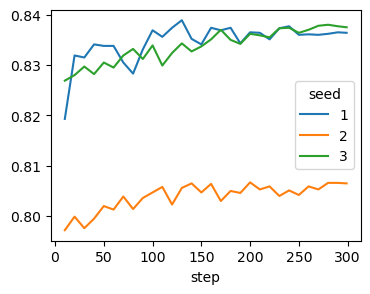

In [82]:
pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../multiseed/vi/cifar10",
        experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in range(1, 4)
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').plot()

In [12]:
SEEDS = range(1, 6+1)
df_sgd_nonseq = pd.concat({
    seed: load_sgd_experiment_logs(
        "../../multiseed/sgd/cifar10",
        experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1)
# df_sgd_nonseq['test/accuracy'].unstack("seed").apply(winsorize, q_low=0.0).plot()
# df_sgd_nonseq.apply(rolling_median).groupby(level="step")['test/accuracy'].agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)]).pipe(lambda df: plot_agg(df, ax=ax, label="SGD"))
SEEDS = range(1, 6+1)
df_mfvi_nonseq = pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../multiseed/vi/cifar10",
        experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median, window=1).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1)


In [13]:
# fig, ax = plt.subplots()
# df_sgd_nonseq.pipe(lambda df: plot_agg(df, ax=ax, label="SGD"))
# df_mfvi_nonseq.pipe(lambda df: plot_agg(df, ax=ax, label="MFVI"))
# ax.legend()
# ax.set_ylabel("Accuracy")
# ax.set_xlabel("Epoch")
# ax.set_title("ResNet-20 FRN Swish on CIFAR10")
# fig.tight_layout()
# # fig.savefig("plots/nonseq_seed1-3.png", dpi=500)
# plt.show()

## Sequential VI

In [81]:
SEEDS = range(1, 14+1)
df_mfvi_split1 = pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../seq_multiseed/cifar10/mfvi_1_of_2",
        experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median, window=3).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1)

df_mfvi_split2 = pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../seq_multiseed/cifar10/mfvi_2_of_2",
        experiment_instance=find_experiment_instance("../.runs/seq_multiseed/cifar10/mfvi_2_of_2", seed)
    )
    for seed in SEEDS
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median, window=3).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1)

df_sgd_split1 = pd.concat({
    seed: load_sgd_experiment_logs(
        "../../seq_multiseed/cifar10/sgd_1_of_2",
        experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1)
df_sgd_split2_from_split1_init = pd.concat({
    seed: load_sgd_experiment_logs(
        "../../seq_multiseed/cifar10/sgd_2_of_2_from_split1_init",
        experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS if seed not in {8}
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median, min_periods=2).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1)

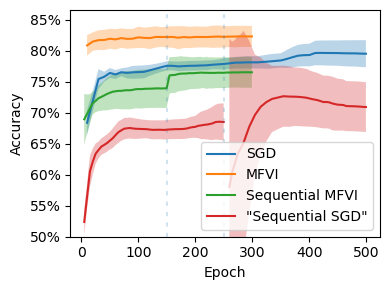

In [76]:
fig, ax = plt.subplots()
plot_agg(df_sgd_nonseq, ax=ax, label="SGD")
plot_agg(df_mfvi_nonseq, ax=ax, label="MFVI")
seq_plot_df = pd.concat([
    df_mfvi_split1,
    df_mfvi_split2.reset_index().assign(step=lambda df: df.step+df_mfvi_split1.index.max()).set_index("step"),
])
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
plot_agg(seq_plot_df, ax=ax, label="Sequential MFVI")
ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
ADD_SGD_BASELINE = True
if ADD_SGD_BASELINE:
    # Add SGD baseline
    seq_plot_df = pd.concat([
        df_sgd_split1,
        df_sgd_split2_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1.index.max()).set_index("step"),
    ])
    seq_plot_df.index /= 2.0
    plot_agg(seq_plot_df, ax=ax, label='"Sequential SGD"')
    ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
# ax.set_title("Sequentially training ResNet-20 FRN Swish on CIFAR10")
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))  # xmax=1 assumes y values are between 0 and 1
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
ax.legend(loc='lower right')
ax.set_ylim(0.5, None)
fig.tight_layout()
# fig.savefig("plots/seq_mfvi_random_split_with_baseline_seed1-10.pdf")
plt.show()

<Axes: xlabel='step'>

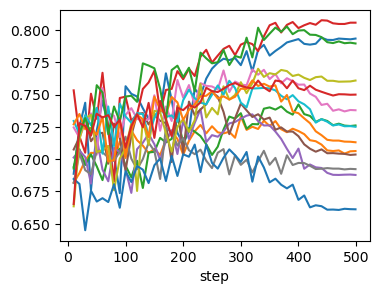

In [77]:
# SGD 2/2 that VI is slightly improving on
pd.concat({
    seed: load_sgd_experiment_logs(
        "../../seq_multiseed/cifar10/sgd_2_of_2",
        experiment_instance=find_experiment_instance("../.runs/seq_multiseed/cifar10/sgd_2_of_2", seed)
    )
    for seed in range(1, 14+1)
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median, window=1).plot(legend=False)

## PCA

<Axes: xlabel='step'>

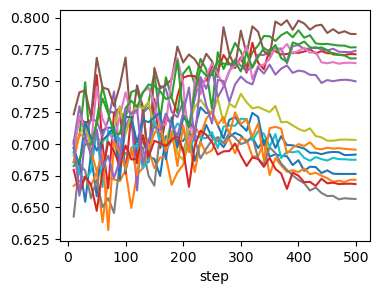

In [67]:
# SGD 2/2 that VI is slightly improving on
pd.concat({
    seed: load_sgd_experiment_logs(
        "../../seq_multiseed/cifar10/sgd_2_of_2_pca",
        experiment_instance=find_experiment_instance("../.runs/seq_multiseed/cifar10/sgd_2_of_2_pca", seed)
    )
    for seed in list(range(1, 15+1))
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').plot(legend=False)

In [69]:
SEEDS = list(range(1, 15+1))
df_mfvi_split1_pca = pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../seq_multiseed/cifar10/mfvi_1_of_2_pca",
        experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median, window=3).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1)

df_mfvi_split2_pca = pd.concat({
    seed: load_mfvi_experiment_logs(
        "../../seq_multiseed/cifar10/mfvi_2_of_2_pca",
        experiment_instance=find_experiment_instance("../.runs/seq_multiseed/cifar10/mfvi_2_of_2_pca", seed)
    )
    for seed in SEEDS
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median, window=3).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1)

df_sgd_split1_pca = pd.concat({
    seed: load_sgd_experiment_logs(
        "../../seq_multiseed/cifar10/sgd_1_of_2_pca",
        experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1)
df_sgd_split2_from_split1_init_pca = pd.concat({
    seed: load_sgd_experiment_logs(
        "../../seq_multiseed/cifar10/sgd_2_of_2_pca_from_split1_init",
        experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
    )
    for seed in SEEDS if seed not in {7, 8, 11}
}, names=["seed", "step"])[TEST_METRIC].unstack('seed').apply(rolling_median, min_periods=2).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1)

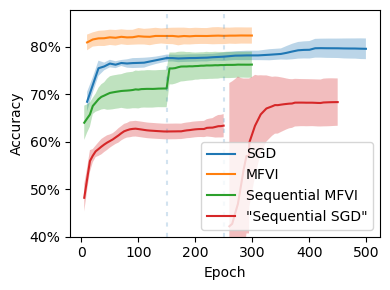

In [78]:
fig, ax = plt.subplots()
plot_agg(df_sgd_nonseq, ax=ax, label="SGD")
plot_agg(df_mfvi_nonseq, ax=ax, label="MFVI")
seq_plot_df = pd.concat([
    df_mfvi_split1_pca,
    df_mfvi_split2_pca.reset_index().assign(step=lambda df: df.step+df_mfvi_split1_pca.index.max()).set_index("step"),
])
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
plot_agg(seq_plot_df, ax=ax, label="Sequential MFVI")
ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
ADD_SGD_BASELINE = True
if ADD_SGD_BASELINE:
    # Add SGD baseline
    seq_plot_df = pd.concat([
        df_sgd_split1_pca,
        df_sgd_split2_from_split1_init_pca.reset_index().assign(step=lambda df: df.step+df_sgd_split1_pca.index.max()).set_index("step"),
    ])
    seq_plot_df.index /= 2.0
    plot_agg(seq_plot_df, ax=ax, label='"Sequential SGD"')
    ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
# ax.set_title("Sequentially training ResNet-20 FRN Swish on CIFAR10")
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))  # xmax=1 assumes y values are between 0 and 1
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
ax.legend(loc='lower right')
ax.set_ylim(0.40, None)
fig.tight_layout()
# fig.savefig("plots/seq_mfvi_pca_split_with_baseline_seed1-3.png", dpi=500)
plt.show()

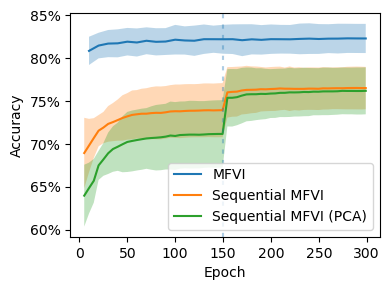

In [80]:
fig, ax = plt.subplots()
plot_agg(df_mfvi_nonseq, ax=ax, label="MFVI")
seq_plot_df = pd.concat([
    df_mfvi_split1,
    df_mfvi_split2.reset_index().assign(step=lambda df: df.step+df_mfvi_split1.index.max()).set_index("step"),
])
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
plot_agg(seq_plot_df, ax=ax, label="Sequential MFVI")
ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
seq_plot_df_pca = pd.concat([
    df_mfvi_split1_pca,
    df_mfvi_split2_pca.reset_index().assign(step=lambda df: df.step+df_mfvi_split1_pca.index.max()).set_index("step"),
])
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df_pca.index /= 2.0
plot_agg(seq_plot_df_pca, ax=ax, label="Sequential MFVI (PCA)")
ax.axvline(x=seq_plot_df_pca.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
# ax.set_title("Sequentially training ResNet-20 FRN Swish on CIFAR10")
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))  # xmax=1 assumes y values are between 0 and 1
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
ax.legend(loc='lower right')
fig.tight_layout()
# fig.savefig("plots/seq_mfvi_single_random_pca_comparison_seed1-10.pdf")
plt.show()